# Stage 1 - Make and train the model - save it to mlflow

In [ ]:
# setup 
!pip install poly-lithic

In [1]:
import pandas as pd
import numpy as np
import torch

## dataset generation
# lets say we want to train a function that returns max(x,y)

input_data = pd.DataFrame({
    'x': np.random.uniform(-1000, 1000, 10000),
    'y': np.random.uniform(-1000, 1000, 10000),
})
output_data = pd.DataFrame({'output': np.maximum(input_data['x'], input_data['y'])})


df = pd.concat([input_data, output_data], axis=1)

df.describe()

,x,y,output
count,10000.000000,10000.000000,10000.000000
mean,4.901299,1.612645,336.349368
std,577.037678,580.885068,474.714531
min,-999.611557,-999.739088,-988.015115
25%,-491.855117,-502.710156,-2.528298
50%,-0.218451,-2.697495,419.745702
75%,509.106061,510.777950,736.750874
max,999.721407,999.892633,999.892633


In [2]:
# mlflow config, assuming you have an mlflow server running
import mlflow
import json, os

json_data = json.load(open('env.json'))  # this or specify manually
os.environ['AWS_DEFAULT_REGION'] = json_data['AWS_DEFAULT_REGION']
os.environ['AWS_REGION'] = json_data['AWS_REGION']
os.environ['AWS_ACCESS_KEY_ID'] = json_data['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = json_data['AWS_SECRET_ACCESS_KEY']
os.environ['MLFLOW_S3_ENDPOINT_URL'] = json_data['MLFLOW_S3_ENDPOINT_URL']
os.environ['MLFLOW_TRACKING_URI'] = json_data['MLFLOW_TRACKING_URI']

In [3]:
# model definition and training
# in this example we are importing the model from a local file, its redundant in this case but it will illustrate how to import extra files.
from mlflow_model.model_definition import SimpleModel

# model training
model = SimpleModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
batch_size = 32


# defining as pyfunc model, this serves as a wrapper for the model, there is a torch flavor but we want a framework agnostic model
class SimpleModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        # define the mlflow prediction function, not really used for much but you can get a trace out of it
        # convert input to torch tensor
        model_input = torch.tensor(model_input.values, dtype=torch.float32)
        # forward pass
        with torch.no_grad():
            predictions = self.model(model_input)
        # convert output to numpy array
        return predictions.numpy()

    def evaluate(self, model_input: dict):  # point to the internal evaluate function
        return self.model.evaluate(model_input)


# convert data to torch tensors
X = torch.tensor(df[['x', 'y']].values, dtype=torch.float32)
y = torch.tensor(df[['output']].values, dtype=torch.float32)

with mlflow.start_run() as run:
    # training loop with mlflow logging
    for epoch in range(100):
        for i in range(0, len(X), batch_size):
            X_batch = X[i : i + batch_size]
            y_batch = y[i : i + batch_size]

            # forward pass
            y_pred = model(X_batch)

            # compute loss
            loss = loss_fn(y_pred, y_batch)

            # backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # log metrics
        mlflow.log_metric('loss', loss.item(), step=epoch)
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    # log model
    wrapped_model = SimpleModelWrapper(model)
    X = pd.DataFrame(X.numpy(), columns=['x', 'y'])
    y = pd.DataFrame(y.numpy(), columns=['output'])
    mlflow.pyfunc.log_model(
        artifact_path='model',
        python_model=wrapped_model,
        # artifacts = {"model_definition": "local/model_definition.py"},  # if you want to include things like weights etc, maybe some images or other files
        signature=mlflow.models.infer_signature(X, y),
        code_paths=['mlflow_model'],
    )
    run_id = run.info.run_id

Epoch 0, Loss: 86.19937133789062
Epoch 1, Loss: 7.189317226409912
Epoch 2, Loss: 0.4881551265716553
Epoch 3, Loss: 1.521618127822876
Epoch 4, Loss: 0.08432275056838989
Epoch 5, Loss: 0.03483305498957634
Epoch 6, Loss: 0.018691901117563248
Epoch 7, Loss: 0.016447871923446655
Epoch 8, Loss: 0.010766732506453991
Epoch 9, Loss: 0.009129096753895283
Epoch 10, Loss: 0.007657382637262344
Epoch 11, Loss: 0.007206145208328962
Epoch 12, Loss: 0.00593187753111124
Epoch 13, Loss: 0.012391813099384308
Epoch 14, Loss: 0.019160643219947815
Epoch 15, Loss: 0.0323420986533165
Epoch 16, Loss: 6.983903408050537
Epoch 17, Loss: 15.07027816772461
Epoch 18, Loss: 9.565503120422363
Epoch 19, Loss: 0.01072756014764309
Epoch 20, Loss: 1.6674065589904785
Epoch 21, Loss: 0.19021661579608917
Epoch 22, Loss: 0.0019454052671790123
Epoch 23, Loss: 0.007591694593429565
Epoch 24, Loss: 0.05970078706741333
Epoch 25, Loss: 86.60699462890625
Epoch 26, Loss: 0.012281314469873905
Epoch 27, Loss: 0.016572866588830948
Epoch 

In [4]:
# we can also register the model to the model registry
mlflow.register_model(
    model_uri='runs:/{}/model'.format(run.info.run_id),
    name='SimpleModel',
)

Registered model 'SimpleModel' already exists. Creating a new version of this model...
2025/06/03 16:57:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SimpleModel, version 4
Created version '4' of model 'SimpleModel'.


<ModelVersion: aliases=[], creation_timestamp=1748966275095, current_stage='None', description='', last_updated_timestamp=1748966275095, name='SimpleModel', run_id='c73805af2cf543748151080bb2351562', run_link='', source='s3://mlflow-bucket/0/c73805af2cf543748151080bb2351562/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='4'>

In [8]:
# load the model
mlflow_model = mlflow.pyfunc.load_model(
    model_uri='models:/SimpleModel/4', suppress_warnings=True
)

# access the wrapped Python model
wrapped_model = mlflow_model.unwrap_python_model()

# call the evaluate method
sample_input = {'x': 20, 'y': 100.0}
sample_output = wrapped_model.evaluate(sample_input)
print(f'Input: {sample_input}, Output: {sample_output}')

# this will confirm the model will load correctly when called by poly-lithic

2025/06/03 17:27:34 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


Input: {'x': 20, 'y': 100.0}, Output: {'output': 100.30054473876953}


# Stage 2 - Write a poly-lithic compatible model  - get model from mlflow

We use the same simple model as in the base-local example, but we defined an mlflow wrapper. 



In this case our `deployment_config.yaml` file will look like this:

``` yaml
deployment:
  type: "continuous"
  rate: 1 #seconds

modules: 
  p4p_server:
    name: "p4p_server"
    type: "interface.p4p_server"
    pub: 
      - "in_interface"
    sub: 
      - "get_all"
      - "out_transformer" # look we can do this now!               
    module_args: None # defines what arguments to pass to the module observer, if any this can inform unpacking etc
    config: 
      EPICS_PVA_NAME_SERVERS: "localhost:5075"
      variables:
        ML:LOCAL:TEST_B:
          proto: pva
          name: ML:LOCAL:TEST_B 
        ML:LOCAL:TEST_A:
          proto: pva
          name: ML:LOCAL:TEST_A
        ML:LOCAL:TEST_S:
          proto: pva
          name: ML:LOCAL:TEST_S
  
  input_transformer:
    name: "input_transformer"
    type: "transformer.SimpleTransformer"
    pub: "in_transformer"
    sub: "in_interface"
    module_args: None
    config:
      symbols:
        - "ML:LOCAL:TEST_B"
        - "ML:LOCAL:TEST_A"
      variables:
        x: # note this is where we change the name to match what the model expects
          formula: "ML:LOCAL:TEST_A"
        y: 
          formula: "ML:LOCAL:TEST_B"
  model:
    name: "model"
    type: "model.SimpleModel" # this is unrelated to our model name its just the name of the Poly-Lithic module
    pub: "model"
    sub: "in_transformer"
    module_args: None
    config:
      type: "MlFlowModelGetter"
      args: 
        model: "SimpleModel"
        model_version: 1
        # or 
        # model_uri: "models:/mlflow_model/1"
      variables:
        max:
          type: "scalar"
  
  output_transformer:
    name: "output_transformer"
    type: "transformer.SimpleTransformer"
    pub: "out_transformer"
    sub: "model"
    module_args: 
      unpack_data: True
    config:
      symbols:
        - "output"
      variables:
        ML:LOCAL:TEST_S:
          formula: "output"

```

Then to launch the model we can use the following command:

``` bash
pl --publish -c examples/base/mlflow_model/deployment_config.yaml -e env.json # or set the environment cariables for the system
```

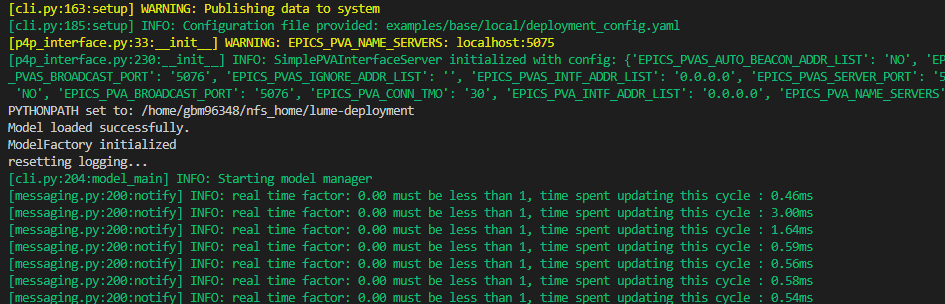

Viewing the output is Phoebus (CS-Studio):

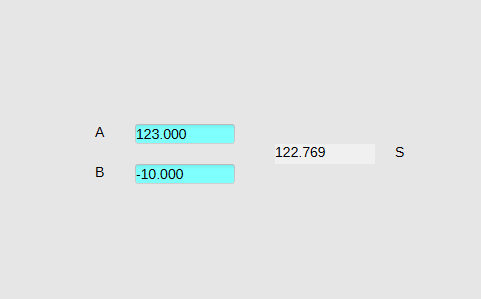